In [77]:
#Import necessary libraries
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def plot_multiple(images, titles, result='result', max_columns=np.inf, figsize=(8, 4), share_axes=True, set_size=False, plot_single=False):
    """Plot multiple images as subplots on a grid."""
    if set_size==True & plot_single==True:
            plt.figure(figsize=figsize)
            for title in titles: plt.title(title)
            for image in images: plt.imshow(image)
    else:
        assert len(images) == len(titles)
        n_images = len(images)
        n_cols = min(max_columns, n_images)
        n_rows = int(np.ceil(n_images / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), 
                                 squeeze=False, sharex=share_axes, sharey=share_axes)
        axes = axes.flat
        # Hide subplots without content
        for ax in axes[n_images:]:
            ax.axis('off')
        for ax, image, title in zip(axes, images, titles):
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(image)
            ax.set_title(title)
        fig.savefig(result)
        fig.tight_layout()

In [79]:
def extract_lines(image, polygon):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gblur = cv2.GaussianBlur(gray,(5,5),0)
    white_areas = cv2.threshold(gblur,200,255,cv2.THRESH_BINARY)[1]
    lower_yellow = np.array([0,100,100])
    upper_yellow = np.array([210,255,255])
    yellow_areas = cv2.inRange(hsv, lower_yellow, upper_yellow)
    bitwise_OR = cv2.bitwise_or(white_areas, yellow_areas)
    return white_areas, yellow_areas, bitwise_OR

In [80]:
def apply_mask(image):
    height, width = image.shape
    img = np.zeros_like(image)
    mask = cv2.fillPoly(img, pts=[polygon], color =(255,255,255))
    masked_image = cv2.multiply(mask, image)
    return mask, masked_image

In [81]:
#Function that unwarps the image
def warp(image, source_points, destination_points, dest_size):
    matrix = cv2.getPerspectiveTransform(source_points, destination_points)
    warped_img = cv2.warpPerspective(image, matrix, dest_size)
    return warped_img

In [82]:
#Function that gives the left fit and right fit curves for the lanes in birdeye's view
def sliding_window(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 50
    margin = 100
    minpix = 50
    window_height = int(img.shape[0]/nwindows)
    y, x = img.nonzero()
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_indices = []
    right_lane_indices = []
    
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        good_left_indices = ((y >= win_y_low) & (y < win_y_high) & (x >= win_xleft_low) & (x < win_xleft_high)).nonzero()[0]
        good_right_indices  = ((y >= win_y_low) & (y < win_y_high) & (x >= win_xright_low) & (x < win_xright_high)).nonzero()[0]
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        if len(good_left_indices) > minpix:
            leftx_current = int(np.mean(x[good_left_indices]))
        if len(good_right_indices) > minpix:
            rightx_current = int(np.mean(x[good_right_indices]))
        
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    return left_lane_indices, right_lane_indices

In [83]:
def poly_fit(img, left_lane_indices, right_lane_indices):
    y, x = img.nonzero()
    leftx = x[left_lane_indices]
    lefty = y[left_lane_indices]
    rightx = x[right_lane_indices]
    righty = y[right_lane_indices]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [84]:
#Function that give pixel location of points through which the curves of detected lanes passes
def get_pixel_location(img_shape, left_fit, right_fit):
    y = np.linspace(0, img_shape[0]-1, img_shape[0])
    r_x = np.polyval(right_fit, y)
    l_x = np.polyval(left_fit, y)
    pts_left = np.array([np.transpose(np.vstack([l_x, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x, y])))])
    return pts_left, pts_right

In [85]:
#Function that fills the space between the detected lane curves
def fill_lane(img_shape, pts_left, pts_right):
    pts = np.hstack((pts_left, pts_right))
    img = np.zeros((img_shape[0], img_shape[1], 3), dtype='uint8')
    cv2.fillPoly(img, np.int_([pts]), (255,0,255))
    return img

In [86]:
#Function that unwarps the image
def unwarp(image, source_points, destination_points, dest_size):
    matrix = cv2.getPerspectiveTransform(destination_points, source_points)
    unwarped_img = cv2.warpPerspective(image, matrix, dest_size)
    return unwarped_img

Video output generated.



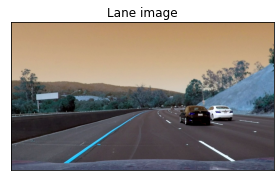

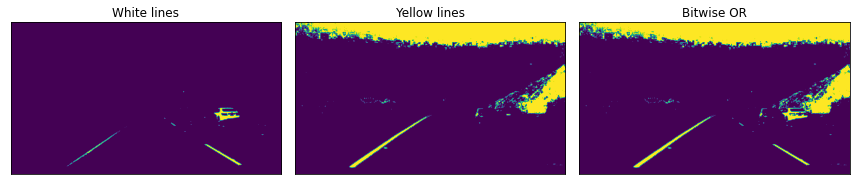

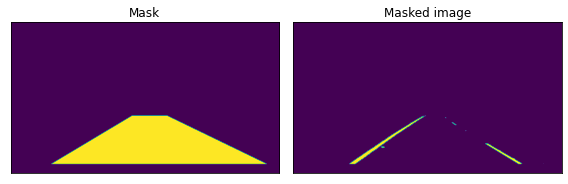

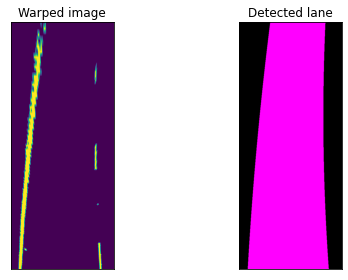

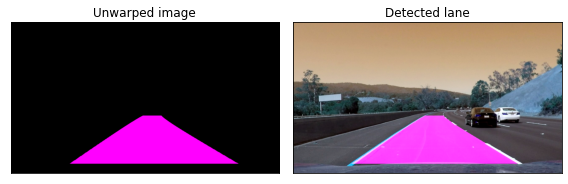

In [87]:
video = cv2.VideoCapture("video/curved_lane.mp4")
out = cv2.VideoWriter('output/curved_lane_detection.avi',cv2.VideoWriter_fourcc(*'XVID'), 25, (1280,720))
first_run=True

while True:
    isTrue, frame = video.read()
    if isTrue == False:
        break
    height, width, channels = frame.shape
    polygon = np.array([(int(width*0.15), int(height*0.94)), (int(width*0.45), int(height*0.62)), 
                    (int(width*0.58), int(height*0.62)), (int(0.95*width), int(0.94*height))])
    white_areas, yellow_areas, bitwise_OR = extract_lines(frame, polygon)
    mask, masked_image = apply_mask(bitwise_OR)
    
    destination_points = np.float32([[0, 960], [0,0], [400,0], [400, 960]])
    source_points = np.float32([[(int(width*0.15), int(height*0.94))], [(int(width*0.45), int(height*0.62))], 
                                [(int(width*0.58), int(height*0.62))], [(int(0.95*width), int(0.94*height))]])
    warped_img = warp(masked_image, source_points, destination_points, (400, 960))
    left_lane_indices, right_lane_indices = sliding_window(warped_img)
    left_fit, right_fit = poly_fit(warped_img, left_lane_indices, right_lane_indices)
    pts_left, pts_right = get_pixel_location(warped_img.shape, left_fit, right_fit)
    detected_lane = fill_lane(warped_img.shape, pts_left, pts_right)
    unwarped_img = unwarp(detected_lane, source_points, destination_points, (width, height))
    output = cv2.addWeighted(frame, 1, unwarped_img, 1, 0)
    
    if first_run==True:
        plot_multiple([frame], ['Lane image'], result='Lane_image')
        plot_multiple([white_areas, yellow_areas, bitwise_OR], 
                      ['White lines', 'Yellow lines', 'Bitwise OR'], result='Detect_lines')
        plot_multiple([mask, masked_image], ['Mask', 'Masked image'], result='masked_img')
        plot_multiple([warped_img, detected_lane], ['Warped image', 'Detected lane'], result='warped')
        plot_multiple([unwarped_img, output], ['Unwarped image', 'Detected lane'], result='final')
        first_run=False
    out.write(output)
out.release()
print("Video output generated.\n")

### Output
<br>
<p align="left"><img width="460" src="curved_lane_detection.gif"></p> 